<div style="background-color:lightgrey">
<font color=red>License Agreement - This software is provided under BSD2 license: </font><br>
    <font color=blue> Copyright &copy; 2019 Denis Osipychev < osipychev at gmail dot com > </font><br>
        <font color=blue size=1pt>Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
        <ul>
            <li>1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
            <li>2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
        </ul>
    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS \"AS IS\" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    </font>
</div>

<h1 align="center"> Generative Adversarial Network (GAN) with MNIST </h1>
<h3 align="center"> by Denis Osipychev < www.denisos.com > </h3>

In this demo, I am building a generative adversarial network (GAN) trained on the MNIST dataset.

GANs were first introduced in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. 

Here is the original paper: https://arxiv.org/abs/1406.2661

<b>Authors:</b>
Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio

<b>Abstract:</b>
We propose a new framework for estimating generative models via an adversarial process, in which we simultaneously train two models: a generative model G that captures the data distribution, and a discriminative model D that estimates the probability that a sample came from the training data rather than G. The training procedure for G is to maximize the probability of D making a mistake. This framework corresponds to a minimax two-player game. In the space of arbitrary functions G and D, a unique solution exists, with G recovering the training data distribution and D equal to 1/2 everywhere. In the case where G and D are defined by multilayer perceptrons, the entire system can be trained with backpropagation. There is no need for any Markov chains or unrolled approximate inference networks during either training or generation of samples. Experiments demonstrate the potential of the framework through qualitative and quantitative evaluation of the generated samples.

### General packages import

In [1]:
# General packages
import numpy as np
import torch
import pickle as pkl

# Data
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.utils.data.dataloader as dataloader

# Torch models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Torch optimization
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Prepare Dataset Loader

In [2]:
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train = MNIST('./data', train=True, download=True, transform=tf)
test = MNIST('./data', train=False, download=True, transform=tf)
### Prepare Dataset
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=64, num_workers=1, pin_memory=True)
test_loader = dataloader.DataLoader(test, shuffle=True, batch_size=64, num_workers=1, pin_memory=True)

### Visualize and Understand the Data

Batch data dimensions:  torch.Size([64, 1, 28, 28])
Batch data distribution:  tensor(-1.) tensor(1.) tensor(-0.7419)


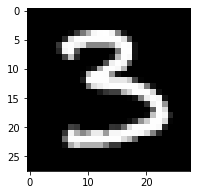

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('Batch data dimensions: ', images.size())
print('Batch data distribution: ', torch.min(images), torch.max(images), torch.mean(images))

# get one image from the batch
images = images.numpy()
img = np.squeeze(images[0])
img_shape = img.shape

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='Greys_r')

### Create a Discriminator

To replicate the paper, the discriminator network is going to be a pretty typical linear classifier. It is similar to the one used in my previous demo and can be easily replaced with CNN or RNN classifier.

In [4]:
class Discriminator(nn.Module):

    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        self.input_size = np.prod(input_shape)
        self.fc1 = nn.Linear(self.input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        out = torch.sigmoid(self.fc3(x))

        return out
    
D = Discriminator(img_shape).to(device)
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Create a Generator

The generator network will be also replicating the architecture proposed in the paper. It follows the discriminator network architecture but inversed (upside down). The generator will create a relatively large output given a small vector in latent-space <b>z</b>. The latent space should be large enough to handle the variety of classes.

The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1 (instead of 0 and 1 for $sigmoid$). 

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, output_shape):
        super(Generator, self).__init__()
        
        self.output_shape = output_shape
        self.output_size = np.prod(output_shape)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, self.output_size)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = torch.tanh(self.fc4(x))

        return out.view(out.size(0), self.output_shape[0],self.output_shape[1])

z_size = 10
G = Generator(z_size, img_shape).to(device)
print(G)

Generator(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Create Optimizers

In GANs, the generator and discriminator variables are updated separately. So, we'll compute two separete sets of losses and utilize two independent Adam optimizers.

In [6]:
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

loss = nn.BCELoss().to(device)

### GAN Training

Training will alternate between training the discriminator and the generator.

#### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Compute the discriminator loss on fake, generated images     
3. Add up real and fake loss
4. Perform an optimization step

#### Generator training
1. Compute the discriminator loss on fake images, using target labels
2. Perform an optimization step

In [7]:
num_epochs = 200
writer = SummaryWriter('./log/gan') #Tensorboard

samples = []
losses = []

# make a fixed vector in latent space to track the evolution of the generator
z_sample = torch.FloatTensor(10, z_size).uniform_(-1., 1.).to(device)

# train the network
D.train()
G.train()

update_step = 0
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
            
        batch_size = real_images.size(0)
        
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # Compute loss with real images
        D_real = D(real_images)
        d_real_loss = loss(D_real.squeeze(), real_labels)
        
        # Compute loss with fake images        
        z = torch.FloatTensor(batch_size, z_size).uniform_(-1., 1.).to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        d_fake_loss = loss(D_fake.squeeze(), fake_labels)
        
        # add up loss and perform backprop step
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        
        # Compute generator loss with fake image
        z = torch.FloatTensor(batch_size, z_size).uniform_(-1., 1.).to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = loss(D_fake.squeeze(), real_labels)
        
        # perform backprop step
        g_loss.backward()
        g_optimizer.step()

        # Print stats
        update_step += 1
        if update_step%100 == 0:
            dl_mean, gl_mean = torch.mean(g_loss), torch.mean(d_loss)
            writer.add_scalar('Loss/Generator', dl_mean, update_step) #Tensorboard
            writer.add_scalar('Loss/Discriminator', gl_mean, update_step) #Tensorboard
            print('\r Epoch [%d/%d] | d_loss: %f | g_loss: %f'%(epoch+1, num_epochs, dl_mean, gl_mean), end="")
    
    
    ## Save progress after each epoch
    losses.append((torch.mean(d_loss), torch.mean(g_loss)))
    
    G.eval()
    sample = G(z_sample)
    samples.append(sample.to('cpu'))
    G.train()

# Save training samples and the generator model
writer.close() #Tensorboard
torch.save(G, './mnist_gan.pkl')
with open('./mnist_gan_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

 Epoch [200/200] | d_loss: 1.246605 | g_loss: 1.082340

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Plot Training Loss

Plot the resulted training losses for the generator and discriminator (can also be seen in Tensorboard).

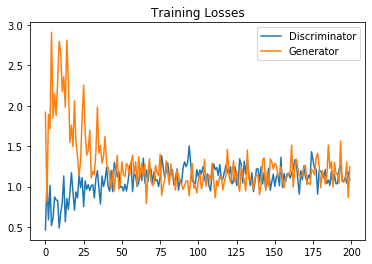

In [8]:
plt.subplots()
losses = np.array(losses)
plt.plot(losses[:,0], label='Discriminator')
plt.plot(losses[:,1], label='Generator')
plt.title('Training Losses')
plt.legend()

### Show the Evolution of the Generator
The generator starts with generating a random noize. After each batch update, the generated images look more similar to those in the real dataset.

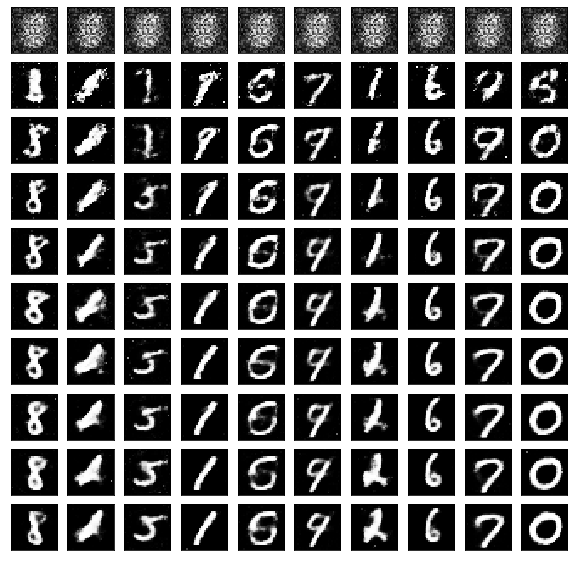

In [9]:
with open('./mnist_gan_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    
fig, axes = plt.subplots(figsize=(10,10), nrows=10, ncols=10, sharex=True, sharey=True)
for i_row in range(10):
    for i_col in range(10):
        img = samples[20*i_row][i_col]
        img = img.detach()
        ax = axes[i_row, i_col]
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Sampling the Generator

We can also get completely new images from the generator by sampling input vectors in the latent space.

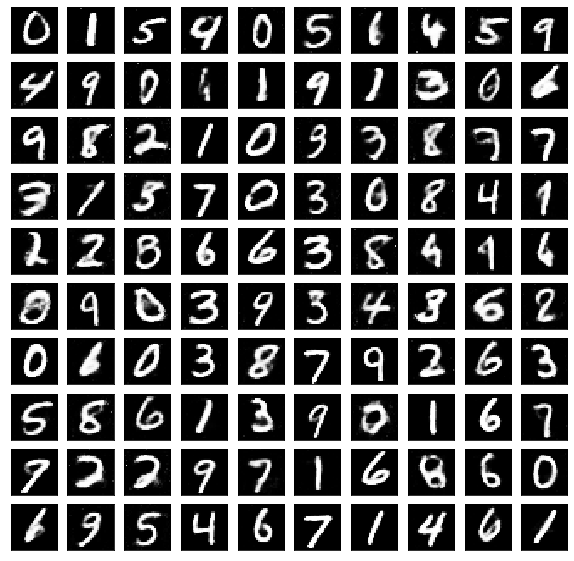

In [10]:
# load generator model
G = torch.load('./mnist_gan.pkl')

# generate random vectors in latent space and pipe them to the generator
sample_size=100
z = torch.FloatTensor(sample_size, z_size).uniform_(-1., 1.)
E = G.eval().to('cpu')
images = G(z)

fig, axes = plt.subplots(figsize=(10,10), nrows=10, ncols=10, sharex=True, sharey=True)
for i in range(100):
    img = images[i]
    img = img.detach()
    ax = axes[i//10, i%10]
    ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)